# Flight Routes

The data is from OpenFlights, a tool that lets you map your flights around the world, search and filter them in all sorts of interesting ways and calculate statistics automatically. I found the Routes dataset from Kaggle, but this lacked mapping data for Airline and Airport IDs, which required me to load all the data from the OpenFlights website. 

Link to OpenFlights data: https://openflights.org/data.html 

Link to Kaggle site: https://www.kaggle.com/open-flights/flight-route-database

## Data Assembly

In [1]:
# install needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import fill
from matplotlib.lines import Line2D
import holoviews as hv
from holoviews import opts, dim
%matplotlib inline

In [2]:
# load data using pandas
airports = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat", 
                       names=['AirportID','AirportName','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','TZName','Type','Source'])
airlines = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat", 
                       names=['AirlineID','AirlineName','AirlineAlias','IATA','ICAO','Callsign','Country','Active'])
routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat", 
                     names=['Airline','AirlineID','SourceAP','SourceAPID','DestinationAP','DestinationAPID','Codeshare','Stops','Equipment'])

In [3]:
#understand what data is included in the different datasets
print('AIRPORTS: \n',airports.head(1))
print('\nAIRLINES: \n',airlines.tail(1))
print('\nROUTES: \n',routes.tail(1))

AIRPORTS: 
    AirportID     AirportName    City           Country IATA  ICAO  Latitude  \
0          1  Goroka Airport  Goroka  Papua New Guinea  GKA  AYGA  -6.08169   

    Longitude  Altitude Timezone DST                TZName     Type  \
0  145.391998      5282       10   U  Pacific/Port_Moresby  airport   

        Source  
0  OurAirports  

AIRLINES: 
       AirlineID    AirlineName       AirlineAlias IATA ICAO         Callsign  \
6161      21317  Svyaz Rossiya  Russian Commuter    7R  SJM  RussianConnecty   

     Country Active  
6161  Russia      Y  

ROUTES: 
       Airline AirlineID SourceAP SourceAPID DestinationAP DestinationAPID  \
67662      ZM     19016      OSS       2913           FRU            2912   

      Codeshare  Stops Equipment  
67662       NaN      0       734  


In [4]:
print('AIRPORTS: \n',airports.describe())
print('\nAIRLINES: \n',airlines.describe())
print('\nROUTES: \n',routes.describe())

AIRPORTS: 
           AirportID     Latitude    Longitude      Altitude
count   7698.000000  7698.000000  7698.000000   7698.000000
mean    5170.950117    25.808442    -1.390546   1015.873344
std     3777.259930    28.404946    86.519162   1628.775132
min        1.000000   -90.000000  -179.876999  -1266.000000
25%     1993.250000     6.907983   -78.974699     63.000000
50%     4068.000000    34.085701     6.375653    352.000000
75%     7728.750000    47.239551    56.000599   1203.000000
max    14110.000000    89.500000   179.951004  14472.000000

AIRLINES: 
           AirlineID
count   6162.000000
mean    4152.723304
std     4507.307094
min       -1.000000
25%     1541.250000
50%     3082.500000
75%     4628.750000
max    21317.000000

ROUTES: 
               Stops
count  67663.000000
mean       0.000163
std        0.012749
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


In [5]:
#add airport and airline data to routes (i.e. names and geography)
airports.AirportID = airports.AirportID.apply(str)
airlines.AirlineID = airlines.AirlineID.apply(str)

data = pd.merge(routes, airlines, on='AirlineID',how='left')
data = data.drop(['AirlineAlias','IATA','ICAO','Callsign','Country','Active','Equipment'],axis=1)
data = pd.merge(data, airports, left_on='SourceAPID', right_on='AirportID',how='left')
data = data.drop(['AirportID','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','TZName','Type','Source'],axis=1)
data = pd.merge(data, airports, left_on='DestinationAPID', right_on='AirportID',how='left')
data = data.drop(['AirportID','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','TZName','Type','Source'],axis=1)
data = data.drop(['AirlineID','SourceAPID','DestinationAPID'],axis=1)

#rename and reorder columns 
data.columns = ['Airline','SourceAP','DestAP','Codeshare','Stops','AirlineName','SourceAirport','SourceCity','SourceCountry','DestAirport','DestCity','DestCountry']
data = data[['Airline','AirlineName','SourceAP','SourceAirport','SourceCity','SourceCountry','DestAP','DestAirport','DestCity','DestCountry','Codeshare','Stops']]
data.head()


Airline AirlineName SourceAP                  SourceAirport   SourceCity  \
0      2B  Aerocondor      AER    Sochi International Airport        Sochi   
1      2B  Aerocondor      ASF              Astrakhan Airport    Astrakhan   
2      2B  Aerocondor      ASF              Astrakhan Airport    Astrakhan   
3      2B  Aerocondor      CEK  Chelyabinsk Balandino Airport  Chelyabinsk   
4      2B  Aerocondor      CEK  Chelyabinsk Balandino Airport  Chelyabinsk   

  SourceCountry DestAP                  DestAirport         DestCity  \
0        Russia    KZN  Kazan International Airport            Kazan   
1        Russia    KZN  Kazan International Airport            Kazan   
2        Russia    MRV     Mineralnyye Vody Airport  Mineralnye Vody   
3        Russia    KZN  Kazan International Airport            Kazan   
4        Russia    OVB           Tolmachevo Airport      Novosibirsk   

  DestCountry Codeshare  Stops  
0      Russia       NaN      0  
1      Russia       NaN      0  
2      Russia       NaN      0  
3      Russia       NaN      0  
4      Russia       NaN      0

## Data Setup for Chord Diagram

Set up data to feed chord diagram in Holoviews. Look up routes from/to country or region based on volume of data. Possibly filter just to international flights.

Intention is to perform exploratory analysis that may lead to more GDP/income-related analysis. For instance, later analyses may involve looking at correlations between wealthier countries and more flight routes to/from those countries. Another could be looking at correlations between # routes and gender equality measures in those countries (from WBL data).

In [6]:
#add continents/regions to group countries at higher level

#import database with country-region mapping
wbl_data = pd.read_excel("wbl_data_50yearpanel_web_27feb2020.xlsx")


In [7]:
#create subset of WBL database to just country & region
regions = pd.DataFrame(data=wbl_data, columns=['Economy','Region'])
regions = pd.DataFrame.drop_duplicates(regions, ignore_index=1)


#standardize country names - replace with names used in Route database so  
regions.replace({'Economy': {'Russian Federation' : 'Russia', 
                             "Côte d'Ivoire" : "Cote d'Ivoire", 
                             'Gambia, The' : 'Gambia',
                             'Egypt, Arab Rep.' : 'Egypt',
                             'Hong Kong SAR, China' : 'Hong Kong',
                             'Taiwan, China' : 'Taiwan',
                             'Bahamas, The' : 'Bahamas',
                             'Venezuela, RB' : 'Venezuela',
                             'St. Lucia' : 'Saint Lucia',
                             'Korea, Rep.' : 'South Korea',
                             'North Macedonia' : 'Macedonia',
                             'Brunei Darussalam' : 'Brunei',
                             'St. Kitts and Nevis' : 'Saint Kitts and Nevis',
                             'Kyrgyz Republic' : 'Kyrgyzstan',
                             'Iran, Islamic Rep.' : 'Iran', 
                             'Puerto Rico (U.S.)' : 'Puerto Rico',
                             'Congo, Dem. Rep.' : 'Congo (Kinshasa)',
                             'Congo, Rep.' : 'Congo (Brazzaville)',
                             'Lao PDR' : 'Laos',
                             'Myanmar' : 'Burma',
                             'Slovak Republic' : 'Slovakia',
                             'São Tomé and Príncipe' : 'Sao Tome and Principe',
                             'Yemen, Rep.' : 'Yemen',
                             'St. Vincent and the Grenadines' : 'Saint Vincent and the Grenadines',
                             'Timor-Leste' : 'East Timor',
                             'Micronesia, Fed. Sts.' : 'Micronesia',
                             'Cabo Verde' : 'Cape Verde',
                             'Eswatini' : 'Swaziland'     }}, inplace=True)




regions.head()

Economy                      Region
0           Afghanistan                  South Asia
1                Angola          Sub-Saharan Africa
2               Albania       Europe & Central Asia
3  United Arab Emirates  Middle East & North Africa
4             Argentina   Latin America & Caribbean

In [8]:
#create country mapping

countries_map = pd.DataFrame(data=data, columns=['SourceCountry'])
countries_map.columns = ['Country']
dest = pd.DataFrame(data=data, columns=['DestCountry'])
dest.columns = ['Country']

countries_map = countries_map.append(dest)
countries_map = pd.DataFrame.dropna(countries_map)
countries_map = pd.DataFrame.drop_duplicates(countries_map, ignore_index=1)

countries_map = pd.merge(countries_map, regions, left_on='Country', right_on='Economy',how='outer')

countries_map.head()

Country        Economy                     Region
0         Russia         Russia      Europe & Central Asia
1     Azerbaijan     Azerbaijan      Europe & Central Asia
2           Peru           Peru  Latin America & Caribbean
3  Cote d'Ivoire  Cote d'Ivoire         Sub-Saharan Africa
4          Ghana          Ghana         Sub-Saharan Africa

In [9]:
#fill null Regions

newcountries = {'Aruba' : 'Latin America & Caribbean', 
                'Netherlands Antilles' : 'Latin America & Caribbean', 
                'French Guiana' : 'Latin America & Caribbean',
                'Martinique' : 'Latin America & Caribbean',
                'Guadeloupe' : 'Latin America & Caribbean',
                'Cuba' : 'Latin America & Caribbean',
                'British Virgin Islands' : 'Latin America & Caribbean',
                'Virgin Islands' : 'Latin America & Caribbean',
                'Turks and Caicos Islands' : 'Latin America & Caribbean',
                'Cayman Islands' : 'Latin America & Caribbean',
                'Bermuda' : 'Latin America & Caribbean',
                'Anguilla' : 'Latin America & Caribbean',
                'Falkland Islands' : 'Latin America & Caribbean',
                
                'Gibraltar' : 'Europe & Central Asia',
                'Guernsey' : 'Europe & Central Asia',
                'Jersey' : 'Europe & Central Asia',
                'Isle of Man' : 'Europe & Central Asia',
                'Faroe Islands' : 'Europe & Central Asia',
                'Turkmenistan' : 'Europe & Central Asia',
                
                'Northern Mariana Islands' : 'East Asia & Pacific',
                'Guam' : 'East Asia & Pacific',
                'French Polynesia' : 'East Asia & Pacific',
                'Cook Islands' : 'East Asia & Pacific',
                'American Samoa' : 'East Asia & Pacific',
                'New Caledonia' : 'East Asia & Pacific',
                'Niue' : 'East Asia & Pacific',
                'Norfolk Island' : 'East Asia & Pacific',
                'Nauru' : 'East Asia & Pacific',
                'Wallis and Futuna' : 'East Asia & Pacific',
                'Cocos (Keeling) Islands' : 'East Asia & Pacific',
                'Christmas Island' : 'East Asia & Pacific',
                'Tuvalu' : 'East Asia & Pacific',
                'North Korea' : 'East Asia & Pacific',
                'Macau' : 'East Asia & Pacific',
                
                'Western Sahara' : 'Middle East & North Africa',
                'Mayotte' : 'Sub-Saharan Africa',
                'Reunion' : 'Sub-Saharan Africa',
                
                #group North American misc. into OECD because other geographical categorizations do not fit
                'Greenland' : 'High income: OECD',
                'Saint Pierre and Miquelon' : 'High income: OECD'
               }



countries_map.Region = countries_map.Region.fillna(countries_map.Country.map(newcountries))

In [10]:
#check that all new countries are properly categorized into Regions
blanks = countries_map[countries_map['Economy'].isnull()]
blanks

Country Economy                      Region
57                       Aruba     NaN   Latin America & Caribbean
58        Netherlands Antilles     NaN   Latin America & Caribbean
63               French Guiana     NaN   Latin America & Caribbean
65                  Martinique     NaN   Latin America & Caribbean
66                  Guadeloupe     NaN   Latin America & Caribbean
70    Northern Mariana Islands     NaN         East Asia & Pacific
80                        Cuba     NaN   Latin America & Caribbean
101                      Macau     NaN         East Asia & Pacific
113                       Guam     NaN         East Asia & Pacific
125                   Anguilla     NaN   Latin America & Caribbean
127     British Virgin Islands     NaN   Latin America & Caribbean
128             Virgin Islands     NaN   Latin America & Caribbean
129   Turks and Caicos Islands     NaN   Latin America & Caribbean
141                    Bermuda     NaN   Latin America & Caribbean
143             Cayman Islands     NaN   Latin America & Caribbean
144                  Gibraltar     NaN       Europe & Central Asia
148           French Polynesia     NaN         East Asia & Pacific
150                   Guernsey     NaN       Europe & Central Asia
151                     Jersey     NaN       Europe & Central Asia
162                    Mayotte     NaN          Sub-Saharan Africa
174                    Reunion     NaN          Sub-Saharan Africa
178             Western Sahara     NaN  Middle East & North Africa
185               Turkmenistan     NaN       Europe & Central Asia
186                Isle of Man     NaN       Europe & Central Asia
190                North Korea     NaN         East Asia & Pacific
200                     Tuvalu     NaN         East Asia & Pacific
204                  Greenland     NaN           High income: OECD
205               Cook Islands     NaN         East Asia & Pacific
206             American Samoa     NaN         East Asia & Pacific
209           Falkland Islands     NaN   Latin America & Caribbean
212              New Caledonia     NaN         East Asia & Pacific
213                       Niue     NaN         East Asia & Pacific
214             Norfolk Island     NaN         East Asia & Pacific
215                      Nauru     NaN         East Asia & Pacific
217  Saint Pierre and Miquelon     NaN           High income: OECD
218              Faroe Islands     NaN       Europe & Central Asia
221          Wallis and Futuna     NaN         East Asia & Pacific
223    Cocos (Keeling) Islands     NaN         East Asia & Pacific
224           Christmas Island     NaN         East Asia & Pacific

In [11]:
#check economies that do not show up in Country list and ensure these are actually distinct from blanks
extras = countries_map[countries_map['Country'].isnull()]
extras

Country               Economy                      Region
225     NaN                Kosovo       Europe & Central Asia
226     NaN            San Marino       Europe & Central Asia
227     NaN  Syrian Arab Republic  Middle East & North Africa
228     NaN    West Bank and Gaza  Middle East & North Africa

In [12]:
countries_map = countries_map.drop(['Economy'],axis=1)
countries_map.head()

Country                     Region
0         Russia      Europe & Central Asia
1     Azerbaijan      Europe & Central Asia
2           Peru  Latin America & Caribbean
3  Cote d'Ivoire         Sub-Saharan Africa
4          Ghana         Sub-Saharan Africa

In [13]:
#check how many airports do not have geographical data

data2 = data


sourceAP = data2[['SourceAP','SourceCity','SourceCountry']]
sourceAP = sourceAP[data2.SourceCountry.isnull()]
sourceAP.columns = ['Airport','City','Country']

destAP = data2[['DestAP','DestCity','DestCountry']]
destAP = destAP[data2.DestCountry.isnull()]
destAP.columns = ['Airport','City','Country']

nullAP = pd.concat([sourceAP,destAP])
nullAP = nullAP.drop_duplicates()
nullAP

Airport City Country
38        TGK  NaN     NaN
54        KCK  NaN     NaN
175       AOS  NaN     NaN
176       KKB  NaN     NaN
178       KOZ  NaN     NaN
...       ...  ...     ...
179       KPR  NaN     NaN
2880      CZJ  NaN     NaN
30028     QFX  NaN     NaN
39955     MTE  NaN     NaN
48450     BSS  NaN     NaN

[204 rows x 3 columns]

In [14]:
#971 routes / 204 airports where geographical data is missing
#too much to look up & populate manually 
#971 out of ~67,700 total row in dataset is not material so I will be removing these lines

data2 = data2.dropna(subset=['SourceCountry', 'DestCountry'])
data2

Airline       AirlineName SourceAP                     SourceAirport  \
0          2B        Aerocondor      AER       Sochi International Airport   
1          2B        Aerocondor      ASF                 Astrakhan Airport   
2          2B        Aerocondor      ASF                 Astrakhan Airport   
3          2B        Aerocondor      CEK     Chelyabinsk Balandino Airport   
4          2B        Aerocondor      CEK     Chelyabinsk Balandino Airport   
...       ...               ...      ...                               ...   
67658      ZL  Regional Express      WYA                   Whyalla Airport   
67659      ZM        Apache Air      DME  Domodedovo International Airport   
67660      ZM        Apache Air      FRU       Manas International Airport   
67661      ZM        Apache Air      FRU       Manas International Airport   
67662      ZM        Apache Air      OSS                       Osh Airport   

        SourceCity SourceCountry DestAP                       DestAirport  \
0            Sochi        Russia    KZN       Kazan International Airport   
1        Astrakhan        Russia    KZN       Kazan International Airport   
2        Astrakhan        Russia    MRV          Mineralnyye Vody Airport   
3      Chelyabinsk        Russia    KZN       Kazan International Airport   
4      Chelyabinsk        Russia    OVB                Tolmachevo Airport   
...            ...           ...    ...                               ...   
67658      Whyalla     Australia    ADL    Adelaide International Airport   
67659       Moscow        Russia    FRU       Manas International Airport   
67660      Bishkek    Kyrgyzstan    DME  Domodedovo International Airport   
67661      Bishkek    Kyrgyzstan    OSS                       Osh Airport   
67662          Osh    Kyrgyzstan    FRU       Manas International Airport   

              DestCity DestCountry Codeshare  Stops  
0                Kazan      Russia       NaN      0  
1                Kazan      Russia       NaN      0  
2      Mineralnye Vody      Russia       NaN      0  
3                Kazan      Russia       NaN      0  
4          Novosibirsk      Russia       NaN      0  
...                ...         ...       ...    ...  
67658         Adelaide   Australia       NaN      0  
67659          Bishkek  Kyrgyzstan       NaN      0  
67660           Moscow      Russia       NaN      0  
67661              Osh  Kyrgyzstan       NaN      0  
67662          Bishkek  Kyrgyzstan       NaN      0  

[66771 rows x 12 columns]

In [15]:
#add source & destination Regions to data

data3 = data2

data3 = pd.merge(data3, countries_map, left_on='SourceCountry', right_on='Country',how='left')
data3 = data3.drop(['Country'],axis=1)
data3 = pd.merge(data3, countries_map, left_on='DestCountry', right_on='Country',how='left')
data3 = data3.drop(['Country'],axis=1)

data3.columns = ['Airline','AirlineName','SourceAP','SourceAirport','SourceCity','SourceCountry','DestAP','DestAirport','DestCity','DestCountry','Codeshare','Stops','SourceRegion','DestRegion']
data3 = data3[['Airline','AirlineName','SourceAP','SourceAirport','SourceCity','SourceCountry','SourceRegion','DestAP','DestAirport','DestCity','DestCountry','DestRegion','Codeshare','Stops']]
data3.tail()


Airline       AirlineName SourceAP                     SourceAirport  \
66766      ZL  Regional Express      WYA                   Whyalla Airport   
66767      ZM        Apache Air      DME  Domodedovo International Airport   
66768      ZM        Apache Air      FRU       Manas International Airport   
66769      ZM        Apache Air      FRU       Manas International Airport   
66770      ZM        Apache Air      OSS                       Osh Airport   

      SourceCity SourceCountry           SourceRegion DestAP  \
66766    Whyalla     Australia      High income: OECD    ADL   
66767     Moscow        Russia  Europe & Central Asia    FRU   
66768    Bishkek    Kyrgyzstan  Europe & Central Asia    DME   
66769    Bishkek    Kyrgyzstan  Europe & Central Asia    OSS   
66770        Osh    Kyrgyzstan  Europe & Central Asia    FRU   

                            DestAirport  DestCity DestCountry  \
66766    Adelaide International Airport  Adelaide   Australia   
66767       Manas International Airport   Bishkek  Kyrgyzstan   
66768  Domodedovo International Airport    Moscow      Russia   
66769                       Osh Airport       Osh  Kyrgyzstan   
66770       Manas International Airport   Bishkek  Kyrgyzstan   

                  DestRegion Codeshare  Stops  
66766      High income: OECD       NaN      0  
66767  Europe & Central Asia       NaN      0  
66768  Europe & Central Asia       NaN      0  
66769  Europe & Central Asia       NaN      0  
66770  Europe & Central Asia       NaN      0

In [16]:
#group routes by domestic v int'l flights
data3['Type'] = np.where(data3['SourceCountry'] == data3['DestCountry'], 'Domestic', 'International')
data3['RouteID'] = data3['SourceCountry'].map(str) + '-' + data3['DestCountry'].map(str)
data3.head()

Airline AirlineName SourceAP                  SourceAirport   SourceCity  \
0      2B  Aerocondor      AER    Sochi International Airport        Sochi   
1      2B  Aerocondor      ASF              Astrakhan Airport    Astrakhan   
2      2B  Aerocondor      ASF              Astrakhan Airport    Astrakhan   
3      2B  Aerocondor      CEK  Chelyabinsk Balandino Airport  Chelyabinsk   
4      2B  Aerocondor      CEK  Chelyabinsk Balandino Airport  Chelyabinsk   

  SourceCountry           SourceRegion DestAP                  DestAirport  \
0        Russia  Europe & Central Asia    KZN  Kazan International Airport   
1        Russia  Europe & Central Asia    KZN  Kazan International Airport   
2        Russia  Europe & Central Asia    MRV     Mineralnyye Vody Airport   
3        Russia  Europe & Central Asia    KZN  Kazan International Airport   
4        Russia  Europe & Central Asia    OVB           Tolmachevo Airport   

          DestCity DestCountry             DestRegion Codeshare  Stops  \
0            Kazan      Russia  Europe & Central Asia       NaN      0   
1            Kazan      Russia  Europe & Central Asia       NaN      0   
2  Mineralnye Vody      Russia  Europe & Central Asia       NaN      0   
3            Kazan      Russia  Europe & Central Asia       NaN      0   
4      Novosibirsk      Russia  Europe & Central Asia       NaN      0   

       Type        RouteID  
0  Domestic  Russia-Russia  
1  Domestic  Russia-Russia  
2  Domestic  Russia-Russia  
3  Domestic  Russia-Russia  
4  Domestic  Russia-Russia

In [17]:
#create subsets of domestic & international routes
domestic = data3[data3['Type'] == 'Domestic']
# domestic.head()
international = data3[data3['Type'] == 'International']
international.head()
# intlroutes = pd.pivot_table(international,index=['SourceRegion', 'SourceCountry'],columns=['DestRegion', 'DestCountry'],values=['Airline'],aggfunc=[len])
# intlroutes

Airline  AirlineName SourceAP                        SourceAirport  \
10      2B   Aerocondor      GYD  Heydar Aliyev International Airport   
24      2B   Aerocondor      NBC                    Begishevo Airport   
77      2J  Air Burkina      ABJ                   Port Bouet Airport   
78      2J  Air Burkina      ABJ                   Port Bouet Airport   
79      2J  Air Burkina      ACC         Kotoka International Airport   

     SourceCity  SourceCountry           SourceRegion DestAP  \
10         Baku     Azerbaijan  Europe & Central Asia    NBC   
24  Nizhnekamsk         Russia  Europe & Central Asia    GYD   
77      Abidjan  Cote d'Ivoire     Sub-Saharan Africa    BOY   
78      Abidjan  Cote d'Ivoire     Sub-Saharan Africa    OUA   
79        Accra          Ghana     Sub-Saharan Africa    OUA   

                            DestAirport        DestCity   DestCountry  \
10                    Begishevo Airport     Nizhnekamsk        Russia   
24  Heydar Aliyev International Airport            Baku    Azerbaijan   
77               Bobo Dioulasso Airport  Bobo-dioulasso  Burkina Faso   
78                  Ouagadougou Airport     Ouagadougou  Burkina Faso   
79                  Ouagadougou Airport     Ouagadougou  Burkina Faso   

               DestRegion Codeshare  Stops           Type  \
10  Europe & Central Asia       NaN      0  International   
24  Europe & Central Asia       NaN      0  International   
77     Sub-Saharan Africa       NaN      0  International   
78     Sub-Saharan Africa       NaN      0  International   
79     Sub-Saharan Africa       NaN      0  International   

                       RouteID  
10           Azerbaijan-Russia  
24           Russia-Azerbaijan  
77  Cote d'Ivoire-Burkina Faso  
78  Cote d'Ivoire-Burkina Faso  
79          Ghana-Burkina Faso

In [18]:
pivot = pd.pivot_table(international,index=['RouteID'],columns=None,values=['Airline'],aggfunc=[len])
pivot = pivot.sort_values(('len','Airline'), ascending=False)
pivot.head(10)

len
                     Airline
RouteID                     
United Kingdom-Spain     518
Spain-United Kingdom     512
Mexico-United States     373
United States-Mexico     369
United States-Canada     364
Canada-United States     363
Germany-Spain            354
Spain-Germany            353
Germany-Italy            221
Italy-Germany            221

In [19]:
#create pivot of all international routes by region, aggregated by number of routes

# pivot = pd.pivot_table(international,index=['SourceRegion','SourceCountry', 'DestRegion','DestCountry'],columns=None,values=['Airline'],aggfunc=[len])
pivot = pd.pivot_table(international,index=['SourceRegion', 'DestRegion'],columns=None,values=['Airline'],aggfunc=[len])
# pivot.sort_values(('len','Airline'), ascending=False)
pivot['values'] = pivot[('len','Airline')]
pivot = pivot.reset_index([0,'SourceRegion','DestRegion'])
pivot = pivot.drop([('len','Airline')],axis=1)
pivot.head(10)

SourceRegion                  DestRegion values
                                                           
0    East Asia & Pacific         East Asia & Pacific   2392
1    East Asia & Pacific       Europe & Central Asia    129
2    East Asia & Pacific           High income: OECD   1208
3    East Asia & Pacific   Latin America & Caribbean      1
4    East Asia & Pacific  Middle East & North Africa    134
5    East Asia & Pacific                  South Asia    167
6    East Asia & Pacific          Sub-Saharan Africa     32
7  Europe & Central Asia         East Asia & Pacific    129
8  Europe & Central Asia       Europe & Central Asia   1266
9  Europe & Central Asia           High income: OECD   1707

In [20]:
#convert Regions to IDs for links in Chord Diagram
pd.DataFrame.drop_duplicates(regions, subset='Region', ignore_index=1)

regionID= pd.DataFrame([['East Asia & Pacific', 0],
                        ['Europe & Central Asia', 1],
                        ['High income: OECD', 2],
                        ['Latin America & Caribbean', 3],
                        ['Middle East & North Africa', 4],
                        ['South Asia', 5],
                        ['Sub-Saharan Africa', 6]
                       ], columns = ['Region', 'RegionID'])

regionID

Region  RegionID
0         East Asia & Pacific         0
1       Europe & Central Asia         1
2           High income: OECD         2
3   Latin America & Caribbean         3
4  Middle East & North Africa         4
5                  South Asia         5
6          Sub-Saharan Africa         6

In [21]:
# replace Region names with Region IDs

links = pd.merge(pivot, regionID, left_on='SourceRegion', right_on='Region', how='left')
links = links.drop(['Region'], axis=1)
links.columns = ['SourceRegion','DestRegion','values','source']

links = pd.merge(links, regionID, left_on='DestRegion', right_on='Region', how='left')
links = links.drop(['SourceRegion','DestRegion','Region'], axis=1)
links.columns = ['value','source','target']
links = links[['source','target','value']]


links.head()

C:\Users\shrut\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


source  target  value
0       0       0   2392
1       0       1    129
2       0       2   1208
3       0       3      1
4       0       4    134

## Generate Chord Diagram

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
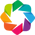

   source  target  value
0       0       0   2392
1       0       1    129
2       0       2   1208


In [22]:
hv.extension('bokeh')
hv.output(size=200)

print(links.head(3))



In [24]:
# create labels for nodes
regionID.columns = ['name','group']
nodes = hv.Dataset(pd.DataFrame(regionID), 'index')


nodes.data.head()

index                        name  group
0      0         East Asia & Pacific      0
1      1       Europe & Central Asia      1
2      2           High income: OECD      2
3      3   Latin America & Caribbean      3
4      4  Middle East & North Africa      4

In [27]:
c = 'Set2'
# 'ColorBlind', 'Category20c'

chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap=c, edge_cmap=c, edge_color=dim('source').str(), 
               labels='name', node_color=dim('index').str()))



:Chord   [source,target]   (value)

In [42]:
#format labels

c = 'Set2'


def rotate_label(plot, element):
    text_cds = plot.handles['text_1_source']
    length = len(text_cds.data['angle'])
    text_cds.data['angle'] = [0]*length
    xs = text_cds.data['x']
    text = np.array(text_cds.data['text'])
    xs[xs<0] -= np.array([len(t)*0.019 for t in text[xs<0]])



chord = hv.Chord((links, nodes)).select(value=(5, None))
chord.opts(
    opts.Chord(cmap=c, edge_cmap=c, edge_color=dim('source').str(), labels='name', node_color=dim('index').str(), 
               width=500, height=500, finalize_hooks=[rotate_label],label_text_font_size='10pt'))



:Chord   [source,target]   (value)

In [43]:
renderer = hv.renderer('bokeh')

plot = renderer.get_plot(chord).state

from bokeh.io import output_file, show
output_file("chord.html")
show(plot)



## Stats for Report

In [47]:
# get top OECD routes

oecd = international[international['SourceRegion'] == 'High income: OECD']
oecd = oecd[oecd['DestRegion'] == 'High income: OECD']

oecd.head()

Airline       AirlineName SourceAP                          SourceAirport  \
111      2L  Helvetic Airways      BDS             Brindisi – Salento Airport   
112      2L  Helvetic Airways      BOD              Bordeaux-Mérignac Airport   
113      2L  Helvetic Airways      BRS                        Bristol Airport   
114      2L  Helvetic Airways      GVA  Geneva Cointrin International Airport   
116      2L  Helvetic Airways      LPA                   Gran Canaria Airport   

       SourceCity   SourceCountry       SourceRegion DestAP  \
111      Brindisi           Italy  High income: OECD    ZRH   
112      Bordeaux          France  High income: OECD    ZRH   
113       Bristol  United Kingdom  High income: OECD    ZRH   
114        Geneva     Switzerland  High income: OECD    LPA   
116  Gran Canaria           Spain  High income: OECD    ZRH   

              DestAirport      DestCity  DestCountry         DestRegion  \
111        Zürich Airport        Zurich  Switzerland  High income: OECD   
112        Zürich Airport        Zurich  Switzerland  High income: OECD   
113        Zürich Airport        Zurich  Switzerland  High income: OECD   
114  Gran Canaria Airport  Gran Canaria        Spain  High income: OECD   
116        Zürich Airport        Zurich  Switzerland  High income: OECD   

    Codeshare  Stops           Type                     RouteID  
111       NaN      0  International           Italy-Switzerland  
112       NaN      0  International          France-Switzerland  
113       NaN      0  International  United Kingdom-Switzerland  
114       NaN      0  International           Switzerland-Spain  
116       NaN      0  International           Spain-Switzerland

In [61]:
len(oecd['Airline']) 
# len(oecd['Airline']) / len(international['Airline'])

13477

In [45]:
pivot = pd.pivot_table(oecd,index=['RouteID'],columns=None,values=['Airline'],aggfunc=[len])
pivot = pivot.sort_values(('len','Airline'), ascending=False)
pivot.head(20)

len
                             Airline
RouteID                             
United Kingdom-Spain             518
Spain-United Kingdom             512
United States-Canada             364
Canada-United States             363
Germany-Spain                    354
Spain-Germany                    353
Italy-Germany                    221
Germany-Italy                    221
United States-United Kingdom     207
United Kingdom-United States     203
Germany-Greece                   176
Greece-Germany                   166
United Kingdom-France            158
France-United Kingdom            157
Spain-France                     151
France-Spain                     149
France-Italy                     149
Italy-France                     148
United Kingdom-Italy             141
Italy-United Kingdom             141

In [63]:
#surprisingly, South Asia has a low number of routes... doing some checks here just to satisfy my curiosity
india = international[international['SourceCountry'] == 'India']
india = southasia[southasia['DestRegion'] == 'High income: OECD']
india

southasia = international[international['SourceRegion'] == 'South Asia']
southasiasum = pd.pivot_table(southasia,index=['SourceCountry'],columns=None,values=['Airline'],aggfunc=[len])
southasiasum

#only 8 countries in South Asia - low proportion could be because of lower number of countries
#also this only shows international routes. I believe there is a large volume of domestic flights in this region

len
              Airline
SourceCountry        
Afghanistan        29
Bangladesh         71
Bhutan              5
India             426
Maldives           40
Nepal              35
Pakistan          166
Sri Lanka         101

In [58]:
sourceoecd = international[international['SourceRegion'] == 'High income: OECD']
destoecd = international[international['DestRegion'] == 'High income: OECD']
anyoecd = sourceoecd.append(destoecd)
anyoecd = pd.DataFrame.drop_duplicates(anyoecd, ignore_index=1)
anyoecd.tail()

Airline AirlineName SourceAP                     SourceAirport  \
24933      ZI  Aigle Azur      QSF                 Ain Arnat Airport   
24934      ZI  Aigle Azur      QSF                 Ain Arnat Airport   
24935      ZI  Aigle Azur      TLM  Zenata – Messali El Hadj Airport   
24936      ZI  Aigle Azur      TLM  Zenata – Messali El Hadj Airport   
24937      ZI  Aigle Azur      VKO     Vnukovo International Airport   

      SourceCity SourceCountry                SourceRegion DestAP  \
24933      Setif       Algeria  Middle East & North Africa    MRS   
24934      Setif       Algeria  Middle East & North Africa    ORY   
24935    Tlemcen       Algeria  Middle East & North Africa    MRS   
24936    Tlemcen       Algeria  Middle East & North Africa    ORY   
24937     Moscow        Russia       Europe & Central Asia    ORY   

                      DestAirport   DestCity DestCountry         DestRegion  \
24933  Marseille Provence Airport  Marseille      France  High income: OECD   
24934          Paris-Orly Airport      Paris      France  High income: OECD   
24935  Marseille Provence Airport  Marseille      France  High income: OECD   
24936          Paris-Orly Airport      Paris      France  High income: OECD   
24937          Paris-Orly Airport      Paris      France  High income: OECD   

      Codeshare  Stops           Type         RouteID  
24933       NaN      0  International  Algeria-France  
24934       NaN      0  International  Algeria-France  
24935       NaN      0  International  Algeria-France  
24936       NaN      0  International  Algeria-France  
24937       NaN      0  International   Russia-France

In [62]:
len(anyoecd['Airline']) 
# len(anyoecd['Airline']) / len(international['Airline'])

24938

In [60]:
len(international['Airline'])

34710